In [1]:
!pip install peakutils
!pip install lineid_plot
!pip install astroquery
!pip install lmfit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 15.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 910.2/910.2 kB 24.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.0/103.0 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.4/98.4 kB 8.5 MB/s eta 0:00:00


In [2]:
from astroquery.linelists.cdms import CDMS
import astropy.units as u
import peakutils
from peakutils.plot import plot as pplot
import matplotlib.pyplot as plt
import pandas as pd
import lineid_plot
from lmfit.models import GaussianModel
import numpy as np
import astropy.constants as c

In [3]:
min_frequency=241.67
max_frequency=241.91
response = CDMS.query_lines(min_frequency= min_frequency* u.GHz,
                            max_frequency=max_frequency * u.GHz,
                            min_strength=-500,
                            molecule="032504 CH3OH, vt=0-2",
                            get_query_payload=False,temperature_for_intensity=0)


In [192]:
# remove duplicates?
#dlist=response['ELO']
#selec=[s for (i, v),s in zip(enumerate(dlist),range(len(dlist))) if i == 0 or v != dlist[i-1]]
#response=response[selec]

In [4]:
line_wave=response['FREQ']/1e3
line_label=[str(i) for i in line_wave]

In [6]:
df = pd.read_csv('mean_spectrum.txt', names = ["Frequency", "Flux"])
freq = df['Frequency']

In [7]:
spe=np.loadtxt('spectra_norm_41sources.txt',delimiter=',')

In [30]:
pd.DataFrame({'Freq':np.array(freq),'Flux':spe[25][1:]}).to_csv('SDC24.381-0.21_3.csv', index=False)

In [12]:
flux=spe[25][1:] #25 ftw

(<Figure size 3000x1500 with 1 Axes>, <Axes: >)

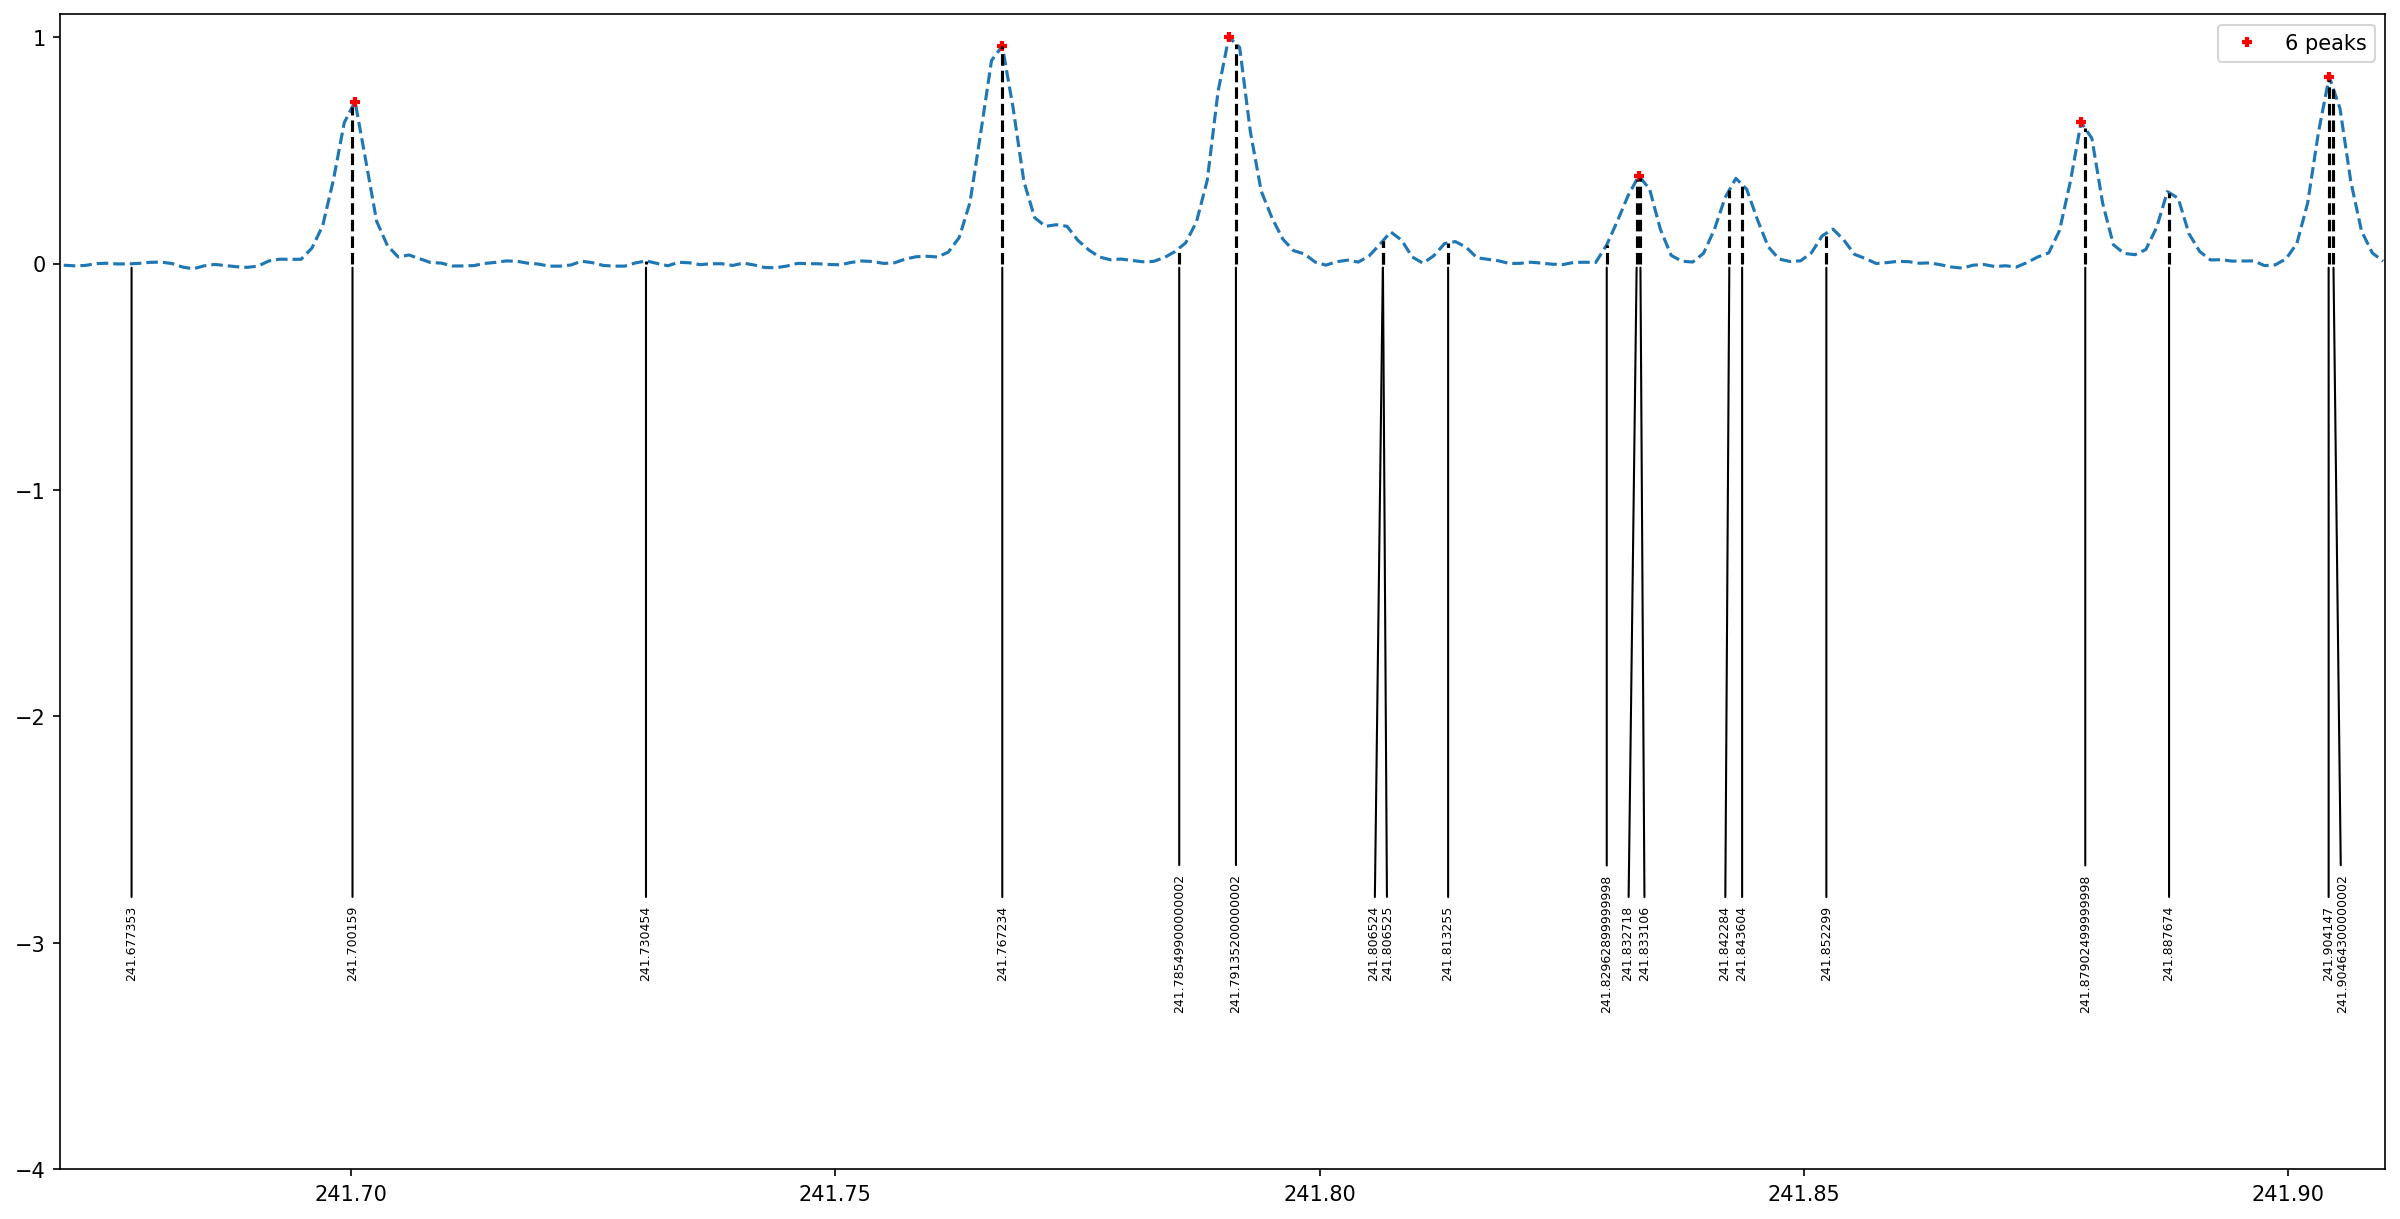

In [14]:
filter=(freq>min_frequency)&(freq<max_frequency)
freqn=freq[filter]
fluxn=flux[filter]

indices = peakutils.indexes(fluxn, thres=0.400, min_dist=0.1)  # indices son las 'posiciones' de los picos
fig, ax = plt.subplots(figsize=(20,10),dpi=150)

pplot(freqn, fluxn, indices)
ax.set_xlim(min_frequency,max_frequency)
ax.set_ylim(-4,1.1)
lineid_plot.plot_line_ids(freqn, fluxn, line_wave, line_label, ax=ax, arrow_tip=0, box_loc=-3, max_iter=300, label1_size=6)

In [15]:
for i,j in zip(line_wave,range(len(line_wave))):
  gausstemp=GaussianModel(prefix='g'+str(j)+'_')

npeaks=len(line_wave)
model=GaussianModel(prefix='g1_')
for i in range(1,npeaks):
  model=model+GaussianModel(prefix='g%d_' % (i+1))
pars=model.make_params()
for i,ff in zip(range(npeaks),line_wave):
  pars['g%d_center' % (i+1)].set(value=ff,vary=False)
  pars['g%d_sigma' % (i+1)].set(value=0.01, min=1e-3,max=0.02)
  pars['g%d_amplitude' % (i+1)].set(value=0.01, min=0,max=0.5)

In [16]:
out=model.fit(fluxn,pars,x=freqn)
#print(out.fit_report(min_correl=0.5))

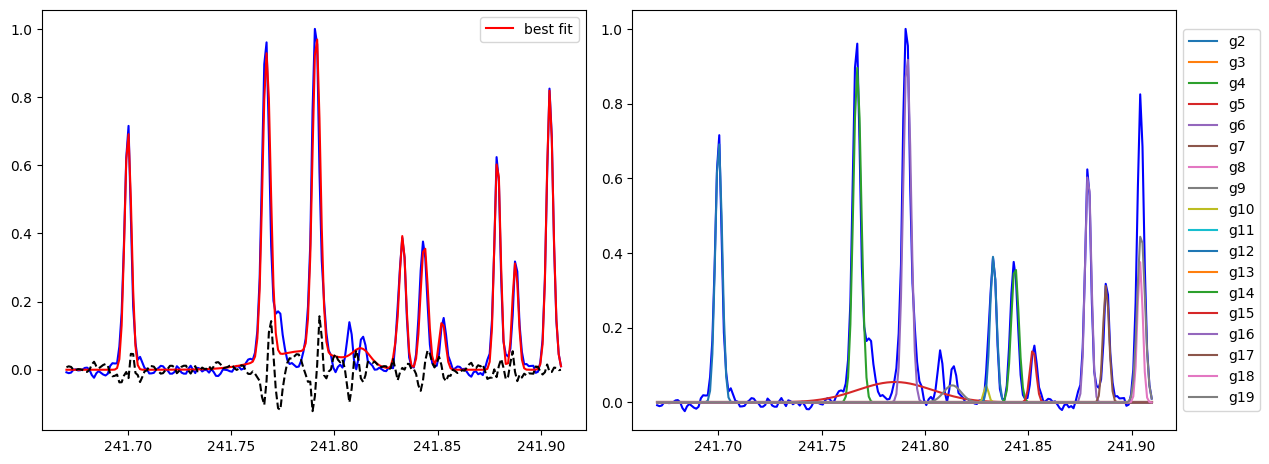

In [17]:
x=freqn
y=fluxn
comps = out.eval_components(x=x)

fig, axes = plt.subplots(1, 2, figsize=(12.8, 4.8))
axes[0].plot(x, y, 'b')
#axes[0].plot(x, init, 'k--', label='initial fit')
axes[0].plot(x, out.best_fit, 'r-', label='best fit')
axes[0].legend(loc='best')
axes[0].plot(x, out.residual, 'k--', label='Residual')


axes[1].plot(x, y, 'b')
for i in range(1,npeaks):
  axes[1].plot(x, comps['g%d_' % (i+1)], label='g'+str(i+1))


axes[1].legend(loc='center left', bbox_to_anchor=(1,0.5))
plt.tight_layout()

In [18]:
dnu=freqn.iloc[1]-freqn.iloc[0]
integ_txt=[np.trapz(comps['g%d_'%(i+1)],dx=dnu) for i in range(npeaks)]
elo=response['ELO']*1.43*u.K*u.cm # cm**-1 to K
etrans=line_wave*0.04799*u.K/u.MHz # GHz**-1 to K
eup=elo+etrans
Aul=10**response['LGAIJ']
gup=response['GUP']
mydict={'Freq':line_wave,'Eup':eup,'Aul':Aul,'gup':gup,'I dv':integ_txt}
df_txt = pd.DataFrame(mydict)
df_txt.to_csv('line_parameters.csv', index=False)


In [19]:
inte=np.array(df_txt['I dv'])*u.Jy*u.GHz
ff=np.array(df_txt['Freq'])*u.GHz
aul=np.array(df_txt['Aul'])/(1*u.s)
NU=((4*np.pi*inte)/(c.h*ff*aul)).cgs
yy=np.log(NU*u.cm**2/df_txt['gup'])
xx=df_txt['Eup']

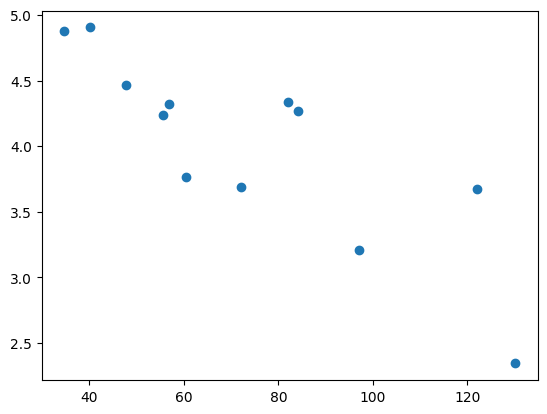

In [23]:
filter2=(df_txt['Eup']<500)&(np.log(NU*u.cm**2/df_txt['gup'])>0)
plt.scatter(xx[filter2],yy[filter2]) #0

Fitted parameters:
m: -0.01975055734877588
c: 5.4614876123394485


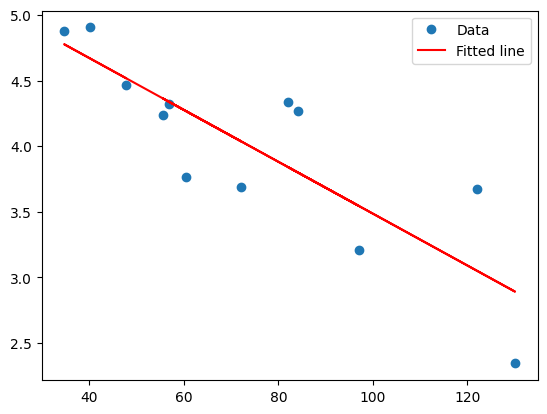

In [24]:
from scipy import optimize as som
def straight_line(x, m, c):
    return m * x + c

popt, pcov = som.curve_fit(straight_line, xx[filter2], yy[filter2])

# Plot the data and the fitted line
plt.plot(xx[filter2], yy[filter2], 'o', label="Data")
plt.plot(xx[filter2], straight_line(xx[filter2], *popt), 'r-', label="Fitted line")

# Print the fitted parameters
print("Fitted parameters:")
print("m:", popt[0])
print("c:", popt[1])

# Show the plot
plt.legend()
plt.show()
#SDC24.381-0.21_3
#18:36:40.60 -07:39:14.000

In [25]:
-1/popt[0]

50.63148256228723

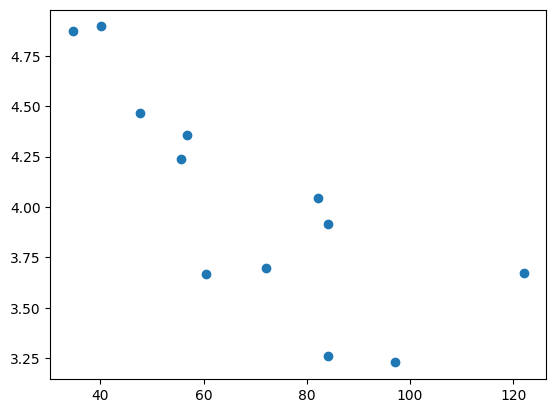

In [220]:
filter2=(df_txt['Eup']<500)&(np.log(NU*u.cm**2/df_txt['gup'])>3)
plt.scatter(xx[filter2],yy[filter2]) #25

Fitted parameters:
m: -0.017268631410604668
c: 5.231122945349567


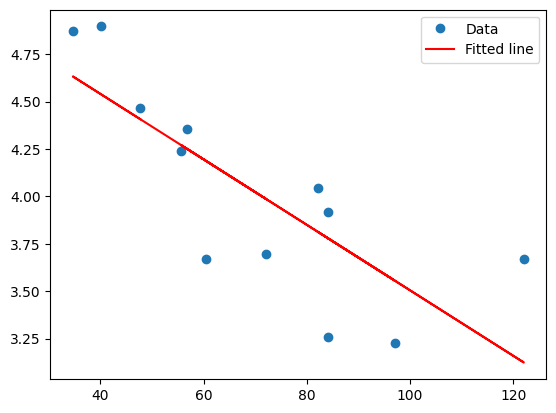

In [222]:
from scipy import optimize as som
def straight_line(x, m, c):
    return m * x + c

popt, pcov = som.curve_fit(straight_line, xx[filter2], yy[filter2])

# Plot the data and the fitted line
plt.plot(xx[filter2], yy[filter2], 'o', label="Data")
plt.plot(xx[filter2], straight_line(xx[filter2], *popt), 'r-', label="Fitted line")

# Print the fitted parameters
print("Fitted parameters:")
print("m:", popt[0])
print("c:", popt[1])

# Show the plot
plt.legend()
plt.show()
#SDC24.381-0.21_3
#18:36:40.60 -07:39:14.000

In [223]:
-1/popt[0]

57.90846861123574

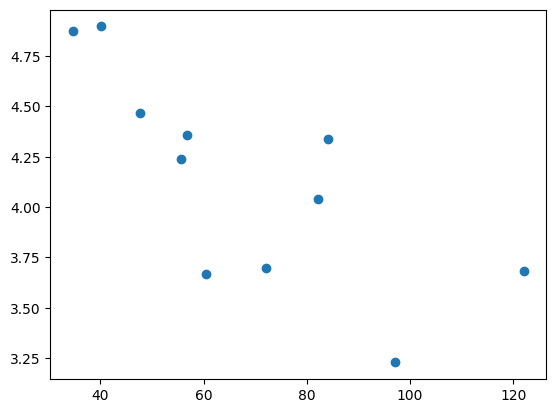

In [208]:
filter2=(df_txt['Eup']<500)&(np.log(NU*u.cm**2/df_txt['gup'])>3)
plt.scatter(xx[filter2],yy[filter2]) #25

In [155]:
df_txt['gup'][filter2]

1     44
3     44
5     44
7     44
8     44
9     44
10    44
11    44
13    44
14    44
15    44
16    44
18    44
Name: gup, dtype: int64

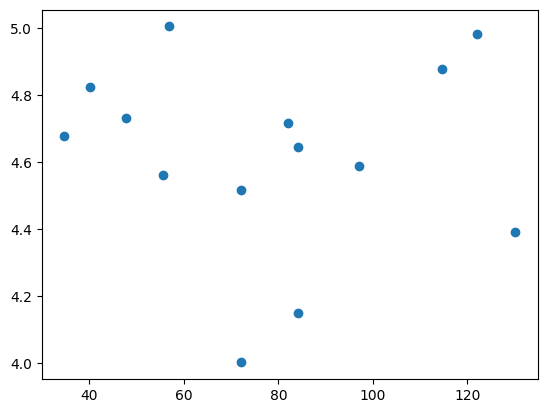

In [110]:
df_txt['gup'][filter2]

1     44
3     44
5     44
7     44
8     44
9     44
10    44
11    44
12    44
13    44
14    44
15    44
16    44
18    44
Name: gup, dtype: int64